<b>Competition:</b> https://www.kaggle.com/c/nyc-taxi-trip-duration/overview <br>

<b>My learnings:</b><br>
<li> Encoding time as sin and cos functions: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/ and https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning (very good resource)
<li> datetime formats in python: http://strftime.org/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
# This method creates a subset of the dataset and writes it to train_subset.csv
# This is done as the entire data set is too vast
original_dataset_csv = "../Datasets/train.csv"
subset_dataset_csv = "../Datasets/train_subset.csv"
def create_subset_of_dataset():
    df = pd.read_csv(original_dataset_csv)
    print(f"Original shape of dataset: {df.shape}")
    sample_size = int(df.shape[0] * 0.1)
    df_subset = df.sample(n=sample_size)
    print(f"Shape of subset dataset: {df_subset.shape}")
    df_subset.to_csv(subset_dataset_csv)
    #print("Now, open the csv file and delete the first (unnamed) column!")

create_subset_of_dataset()

Original shape of dataset: (1458644, 11)
Shape of subset dataset: (145864, 11)


In [3]:
df = pd.read_csv(subset_dataset_csv)
df.head()

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,133824,id3174676,2,2016-01-02 18:09:46,2016-01-02 18:20:39,1,-73.985878,40.745041,-74.007378,40.727280,N,653
1,923482,id1536515,1,2016-02-20 02:01:14,2016-02-20 02:14:35,1,-73.993668,40.741623,-73.952652,40.791012,Y,801
2,244194,id0509364,1,2016-01-21 09:32:22,2016-01-21 09:47:44,1,-73.954178,40.770271,-73.965828,40.759613,N,922
3,1416196,id3372978,1,2016-01-04 21:18:14,2016-01-04 21:23:18,1,-73.975418,40.750423,-73.974564,40.761631,N,304
4,901159,id3953774,1,2016-05-12 21:00:14,2016-05-12 21:07:08,1,-73.995155,40.745350,-73.992485,40.756195,N,414


In [4]:
# Drop the column C0 as it corresponds to the row number from the original csv file
df = df.drop(['Unnamed: 0'], axis=1)

# Drop the column store_and_fwd_flag as we hypothesize that it will not affect the trip duration
df = df.drop(['store_and_fwd_flag'], axis=1)
df.describe()
print(f"Number of null values in the dataset: {df.isnull().any().sum()}")

Number of null values in the dataset: 0


In [5]:
def one_hot_encoding(column):
    ohe_enc = OneHotEncoder(sparse=False)
    ohe_enc.fit(column)
    result = ohe_enc.transform(column)
    return result

In [6]:
def encode_cyclic_values(data, max_val, col_name):
    encoded_data = pd.DataFrame()
    # Sine transformation
    encoded_data[col_name + '_sin'] = np.sin(2* np.pi * data / max_val)
    # Cos transformation
    encoded_data[col_name + '_cos'] = np.cos(2 * np.pi * data / max_val)
    return encoded_data

In [7]:
def label_encode_bearing(bearing_values):
    # North is between -45.0 and 45.0. Label: 1
    bearing_values[np.logical_and(bearing_values>=-45.0, bearing_values<45.0)] = 1.0

    # East is between 45.0 and 135.0 Label: 2
    bearing_values[np.logical_and(bearing_values>=45.0, bearing_values<135.0)] = 2.0
    
    # South is between -135.0 to -180.0 and 135.0 to 180.0 Label: 3
    bearing_values[np.logical_and(bearing_values<-135.0, bearing_values>=-180.0)] = 3.0
    bearing_values[np.logical_and(bearing_values>=135.0, bearing_values<=180.0)] = 3.0
    
    # West is between -45.0 and -135.0 Label: 4
    bearing_values[np.logical_and(bearing_values<-45.0, bearing_values>=-135.0)] = 4.0
    return bearing_values

In [8]:
def preprocess_datetime_values(column):
    # Split the datetime value into date and time components
    date_time_values = pd.DataFrame()
    # Split the datetime column into 2 columns: date and time
    temp = column.str.split(' ')
    date_time_values['date'] = temp.str[0]
    date_time_values['time'] = temp.str[1]
    
    # Extract the year value from the dates
    date_time_values['year'] = date_time_values['date'].str.split('-').str[0]
    
    # Get day# of the year from the dates and perform sin, cos transformations
    dates = pd.to_datetime(date_time_values['date'])
    date_time_values['day_number'] = pd.to_numeric(dates.dt.strftime('%j'))
    encoded_dates = encode_cyclic_values(date_time_values['day_number'], 366, 'day_number')
    date_time_values['day_number_sin'] = encoded_dates['day_number_sin']
    date_time_values['day_number_cos'] = encoded_dates['day_number_cos']
    
    # Convert time into seconds past midnight and perform sin, cos transformations
    temp = date_time_values['time'].str.split(':')
    date_time_values['hour'] = pd.to_numeric(temp.str[0])
    date_time_values['minute'] = pd.to_numeric(temp.str[1])
    date_time_values['second'] = pd.to_numeric(temp.str[2])
    date_time_values['seconds_past_midnight'] = (date_time_values['hour']*3600) + ((date_time_values['minute']*60)) + (date_time_values['second']) 
    encoded_times = encode_cyclic_values(date_time_values['seconds_past_midnight'], 86400, 'time')
    date_time_values['time_sin'] = encoded_times['time_sin']
    date_time_values['time_cos'] = encoded_times['time_cos']
    
    return date_time_values

In [9]:
def haversine(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    radius_of_earth = 6378.1  # In km
    lat_delta = dropoff_lat - pickup_lat
    lon_delta = dropoff_long - pickup_long
    d = np.sin(lat_delta*0.5)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(lon_delta*0.5)**2
    haversine_values = 2 * radius_of_earth * np.arcsin(np.sqrt(d))
    haversine_values = np.reshape(haversine_values, (haversine_values.shape[0],1))
    return haversine_values

In [10]:
# Get latitude dist with long_delta = 0. Then get lon dist with lat_delta = 0. 
# Then add both values to get the the manhattan distance wrt to lat & long coordinates.
# Reference: https://stackoverflow.com/questions/32923363/manhattan-distance-for-two-geolocations

def manhattan_distance(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    lat_distance = haversine(pickup_lat, pickup_long, dropoff_lat, pickup_long)
    long_distance = haversine(pickup_lat, pickup_long, pickup_lat, dropoff_long)
    man_dist = lat_distance + long_distance
    return man_dist

In [11]:
def bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    radius_of_earth = 6378.1  # In km
    lon_delta = dropoff_long - pickup_long
    y = np.sin(lon_delta) * np.cos(dropoff_lat)
    x = np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(lon_delta)
    bearing_values = np.degrees(np.arctan2(y, x))
    bearing_values = np.reshape(bearing_values, (bearing_values.shape[0],1))
    label_enc_bearing_values = label_encode_bearing(bearing_values)
    ohe_enc_bearing_values = one_hot_encoding(label_enc_bearing_values)
    return ohe_enc_bearing_values

In [12]:
def preprocess_geospatial_values(data):
    # Columns after converting df to np array:
    # 0: pickup_latitude, 1: pickup_longitude, 2: dropoff_latitude, 3: dropoff_longitude
    data_radians = np.radians(data)
    
    # Haversine formula to calculate the distance between the 2 coordinates
    enc_geospatial_data = haversine(data_radians[:,0], data_radians[:,1], data_radians[:,2], data_radians[:,3])
    
    # Manhattan distance between the pickup and dropoff coordinates
    man_dist = manhattan_distance(data_radians[:,0], data_radians[:,1], data_radians[:,2], data_radians[:,3])
    enc_geospatial_data = np.append(enc_geospatial_data, man_dist, axis=1)
    
    # Calculate the bearing (i.e direction) between the coordinates. Then, perform O-H-E.
    bearing_values = bearing(data_radians[:,0], data_radians[:,1], data_radians[:,2], data_radians[:,3])
    enc_geospatial_data = np.append(enc_geospatial_data, bearing_values, axis=1)
    
    # Calculate the center-points of the latitudes and longitudes (in degrees)
    latitude_centers = data[:,2] - data[:,0]
    longitude_centers = data[:,3] - data[:,1]
    latitude_centers = np.reshape(latitude_centers, (latitude_centers.shape[0],1))
    longitude_centers = np.reshape(longitude_centers, (longitude_centers.shape[0],1))
    enc_geospatial_data = np.append(enc_geospatial_data, latitude_centers, axis=1)
    enc_geospatial_data = np.append(enc_geospatial_data, longitude_centers,axis=1)
    return enc_geospatial_data

In [13]:
def remove_spurious_data(raw_data):
    # Decided on a threshold time of 20000 seconds for a trip after analysing the dataset
    threshold_of_trip_time = 20000
    
    # Remove records with null values from the dataset
    print(f"Number of null values in the dataset: {raw_data.isnull().any().sum()}")
    raw_data = raw_data[raw_data.notnull()]
    
    # Remove records with trip times greater than the given threshold
    raw_data = raw_data[raw_data.trip_duration < 20000]
    return raw_data

In [14]:
def preprocess_data(raw_data):
    # Add the id column without any pre-processing
    clean_data = np.array(raw_data['id'])
    clean_data = np.reshape(clean_data, (clean_data.shape[0],1))
    
    # One-hot-encode the vendor_id column
    vendor_id_raw = np.array(raw_data['vendor_id'])
    vendor_id_raw = np.reshape(vendor_id_raw, (vendor_id_raw.shape[0],1))
    vendor_id_clean = one_hot_encoding(vendor_id_raw)
    clean_data = np.append(clean_data, vendor_id_clean, axis=1)
    
    # For pickup_datetime column, split the datetime field and:
    #  i.  Retain year as a seperate feature
    # ii.  Combine month and date to get day# and perform sine & cos encoding on it
    # iii. Convert time to seconds_past_midnight and perform sine & cos encoding on it
    pickup_datetime_split = preprocess_datetime_values(raw_data['pickup_datetime'])
    
    # Add year column after O-H-E
    year_values = np.array(pickup_datetime_split['year'])
    year_values = np.reshape(year_values, (year_values.shape[0],1))
    year_values_OHE = one_hot_encoding(year_values)
    clean_data = np.append(clean_data, year_values_OHE, axis=1)
    
    # Add day_number_sin column
    day_number_sin = np.array(pickup_datetime_split['day_number_sin'])
    day_number_sin = np.reshape(day_number_sin, (day_number_sin.shape[0],1))
    clean_data = np.append(clean_data, day_number_sin, axis=1)
    
    # Add day_number_cos column
    day_number_cos = np.array(pickup_datetime_split['day_number_cos'])
    day_number_cos = np.reshape(day_number_cos, (day_number_cos.shape[0],1))
    clean_data = np.append(clean_data, day_number_cos, axis=1)
    
    # Add time_sin column
    pickup_time_sine = np.array(pickup_datetime_split['time_sin'])
    pickup_time_sine = np.reshape(pickup_time_sine, (pickup_time_sine.shape[0],1))
    clean_data = np.append(clean_data, pickup_time_sine,axis=1)
    
    # Add time_cos column
    pickup_time_cos = np.array(pickup_datetime_split['time_cos'])
    pickup_time_cos = np.reshape(pickup_time_cos, (pickup_time_cos.shape[0],1))
    clean_data = np.append(clean_data, pickup_time_cos, axis=1)
    
    # For dropoff_datetime column, split the datetime field and
    # perform the same actions as performed on pickup_datetime
    dropoff_datetime_split = preprocess_datetime_values(raw_data['dropoff_datetime'])
    
    # Add year column after O-H-E
    year_values = np.array(dropoff_datetime_split['year'])
    year_values = np.reshape(year_values, (year_values.shape[0],1))
    year_values_OHE = one_hot_encoding(year_values)
    clean_data = np.append(clean_data, year_values_OHE, axis=1)
    
    # Add day_number_sin column
    day_number_sin = np.array(dropoff_datetime_split['day_number_sin'])
    day_number_sin = np.reshape(day_number_sin, (day_number_sin.shape[0],1))
    clean_data = np.append(clean_data, day_number_sin, axis=1)
    
    # Add day_number_cos column
    day_number_cos = np.array(dropoff_datetime_split['day_number_cos'])
    day_number_cos = np.reshape(day_number_cos, (day_number_cos.shape[0],1))
    clean_data = np.append(clean_data, day_number_cos, axis=1)
    
    # Add time_sin column
    dropoff_time_sine = np.array(dropoff_datetime_split['time_sin'])
    dropoff_time_sine = np.reshape(dropoff_time_sine, (dropoff_time_sine.shape[0],1))
    clean_data = np.append(clean_data, dropoff_time_sine,axis=1)
    
    # Add time_cos column
    dropoff_time_cos = np.array(dropoff_datetime_split['time_cos'])
    dropoff_time_cos = np.reshape(dropoff_time_cos, (dropoff_time_cos.shape[0],1))
    clean_data = np.append(clean_data, dropoff_time_cos, axis=1)
    
    # Add passenger_count column without any preprocessing
    passenger_count = np.array(raw_data['passenger_count'])
    passenger_count = np.reshape(passenger_count, (passenger_count.shape[0],1))
    clean_data = np.append(clean_data, passenger_count, axis=1)
    
    # To encode geo-spatial data, the following techniques have been used:
    #   i. Haversine formula: https://plus.maths.org/content/lost-lovely-haversine
    #  ii. Manhattan distance: https://xlinux.nist.gov/dads/HTML/manhattanDistance.html
    # iii. Bearing: https://www.igismap.com/formula-to-find-bearing-or-heading-angle-between-two-points-latitude-longitude/
    #  iv. Center lat and long b/w pickup and dropoff points
    # Reference: https://mlwhiz.com/blog/2017/09/14/kaggle_tricks/
    raw_geospatial_data = np.array(raw_data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])
    encoded_geospatial_data = preprocess_geospatial_values(raw_geospatial_data)
    clean_data = np.append(clean_data, encoded_geospatial_data, axis=1)
    
    # Add the trip_duration column as it is, without any preprocessing. This is the label.
    labels_column = np.array(raw_data['trip_duration'])
    labels_column = np.reshape(labels_column, (labels_column.shape[0],1))
    clean_data = np.append(clean_data, labels_column, axis=1)
    
    return clean_data

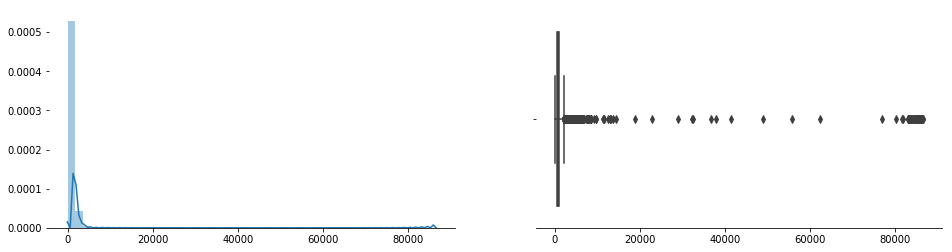

In [15]:
# Distribution of trip durations
duration = [df['trip_duration'].values]
f, axes = plt.subplots(1,2, figsize=(16,4), sharex=True)
sns.despine(left=True)
sns.distplot(duration, ax=axes[0])
sns.boxplot(duration, ax=axes[1])

In [16]:
# The data has been preprocessed
print(df.shape)
df2 = remove_spurious_data(df)
print(df2.shape)
clean_data = preprocess_data(df2)
print(clean_data[0])

(145864, 10)
Number of null values in the dataset: 0
(145667, 10)
['id3174676' 0.0 1.0 1.0 0.034327600513243496 0.9994106342455052
 -0.9990921130739061 0.04260222521790595 1.0 0.034327600513243496
 0.9994106342455052 -0.9959435041941422 0.08998075601756532 1
 2.6828768541061803 3.7903860558494964 0.0 0.0 1.0 0.0 -0.01776123046875
 -0.02149963378907671 653]


In [17]:
print(np.unique(clean_data[:,3]))

[1.0]


In [18]:
# Split into data and labels
data = clean_data[:,:-1]
labels = clean_data[:,-1]

# Split the data into train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [19]:
# Use cross validation to find a model that gives the least error (using mean absolute error)

# Linear Regression on the model
lin_reg_cv_score = cross_val_score(LinearRegression(), data[:,1:], labels, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
print(f"Mean absolute error with Linear Regression is: {lin_reg_cv_score}\n")

# MLP on the model
mlp_cv_score = cross_val_score(MLPRegressor(), data[:,1:], labels, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
print(f"Mean absolute error for MLP is: {mlp_cv_score}\n")

# Decision Tree Regressor
tree_reg_cv_score = cross_val_score(DecisionTreeRegressor(), data[:,1:], labels, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
print(f"Mean absolute error with Decision Tree Regressor is: {tree_reg_cv_score}\n")

# Random Forest Regressor
forest_reg_cv_score = cross_val_score(RandomForestRegressor(), data[:,1:], labels, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
print(f"Mean absolute error with Random Forest Regressor is: {forest_reg_cv_score}")

Mean absolute error with Linear Regression is: [-151650.83660755 -161018.26084484 -250389.05378367 -237691.98844644
 -144618.95369183 -144729.44795361 -178010.31262386 -144637.26050024
 -140189.09369832 -157077.53605079]

Mean absolute error for MLP is: [-112338.04527051 -120385.32787795 -101679.68674254  -93990.05703954
 -110141.57500794 -109000.84106855 -147443.46506806 -114509.12379815
 -105045.12869099 -120344.71719573]

Mean absolute error with Decision Tree Regressor is: [-216029.54685247 -195558.84210888 -208846.70611656 -175365.93814787
 -187213.45575616 -195501.59099334 -231929.86730281 -202987.01901689
 -187006.63469724 -189647.335576  ]

Mean absolute error with Random Forest Regressor is: [-113560.50764468 -120298.32229903 -108547.18873344 -101679.14733576
 -108202.89972197 -103782.04811217 -135897.24659642 -114537.08029383
  -97970.50624743 -107796.4854792 ]


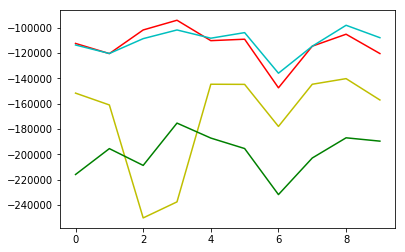

In [33]:
plt.plot(lin_reg_cv_score, 'y')
plt.plot(mlp_cv_score, 'r')
plt.plot(tree_reg_cv_score, 'g')
plt.plot(forest_reg_cv_score, 'c')


As seen from the above error graph, MLP (red) and Random Forest Regressor (cyan) give the least error (RMSE). Comparing the errors between them:

Number of times Random Forest gave lesser error than MLP: 6
Number of times MLP gave lesser error than Random Forest: 4


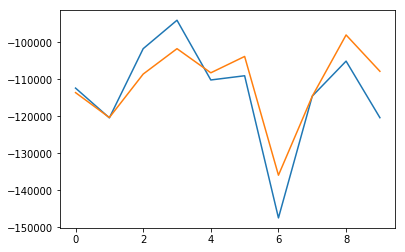

In [34]:
# Compare error
plt.plot(mlp_cv_score)
plt.plot(forest_reg_cv_score)
forest_count = 0;
mlp_count = 0

for forest,mlp in zip(mlp_cv_score, forest_reg_cv_score):
    if forest > mlp:
        mlp_count += 1
    else:
        forest_count += 1
print(f"Number of times Random Forest gave lesser error than MLP: {forest_count}")
print(f"Number of times MLP gave lesser error than Random Forest: {mlp_count}")

We see that RF performs better than MLP, but only just. Hence, let's choose both models and see the results of making an ensemble out of them.

In [ ]:
# Since Random Forest Regressor gives the lowest error among all models, we will use
# GridSearchCV to tune the hyper-parameters for RF Regressor and minimize the error

print(datetime.now())

rf_parameters = {'n_estimators':[10,50,100,200,500,750], 'criterion':['mse','mae'],
                 'max_depth':[20,50,100,None], 'min_samples_leaf':[2,5,10,20]}
rf_gsc = GridSearchCV(RandomForestRegressor(), param_grid=rf_parameters, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
grid_search_result = rf_gsc.fit(X_train[:1000,1:],y_train[:1000])
print(f"The best set of hyper-parameters are: {grid_search_result.best_params_}")

print(datetime.now())

2019-06-20 23:00:08.266957
